# IEEE-CIS Fraud Detection competition

***Sukčiavimo nustatymas iš klientų sandorių***

1. Duomenenų, bibliotekų ir paketų importas 
2. Duomenų analizė
3. Duomenų paruošimas
4. Modelio parinkimas
5. Rezultato suformavimas 

## 1. Duomenų, bibliotekų ir paketų importas

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn import preprocessing
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import time
import matplotlib.patches as mpatches
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import warnings
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from collections import Counter
warnings.simplefilter("ignore")

Atminties mažinimo funkcija, kuri konvertuoja kintamųjų duomenų formatą ('int16', 'int32', 'int64', 'float16', 'float32', 'float64') į mažiausią įmanomą formatą.

In [31]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

Duomenų importas.

In [32]:
%%time 
train_transactions = pd.read_csv('C:/Users/girza/Documents/SDA/data_fraud_detection/train_transaction.csv')
test_transaction =   pd.read_csv('C:/Users/girza/Documents/SDA/data_fraud_detection/test_transaction.csv')
train_identity =     pd.read_csv('C:/Users/girza/Documents/SDA/data_fraud_detection/train_identity.csv')
test_identity =      pd.read_csv('C:/Users/girza/Documents/SDA/data_fraud_detection/test_identity.csv')
sample_submission =  pd.read_csv('C:/Users/girza/Documents/SDA/data_fraud_detection/sample_submission.csv')
print('Data is loaded!')

Data is loaded!
Wall time: 27.4 s


In [33]:
%%time 
train_df = train_transactions.merge(train_identity, how="left", on="TransactionID")
test_df =  test_transaction.merge(test_identity,    how="left", on="TransactionID")
print('Data is merged!')

Data is merged!
Wall time: 10 s


In [34]:
del train_transactions, train_identity, test_transaction, test_identity

In [35]:
%%time
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Mem. usage decreased to 650.48 Mb (66.8% reduction)
Mem. usage decreased to 565.37 Mb (66.3% reduction)
Wall time: 2min 11s


In [36]:
print('Train shape', train_df.shape)
print('Test shape ',  test_df.shape)

Train shape (590540, 434)
Test shape  (506691, 433)


In [37]:
display(train_df.head())
display(test_df.head())

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,id-31,id-32,id-33,id-34,id-35,id-36,id-37,id-38,DeviceType,DeviceInfo
0,3663549,18403224,31.953125,W,10409,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3663550,18403263,49.000000,W,4272,111.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3663551,18403310,171.000000,W,4476,574.0,150.0,visa,226.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3663552,18403310,285.000000,W,10989,360.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3663553,18403317,67.937500,W,18018,452.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Kintamųjų vardų palyginimas *train_df* ir *train_df* rinkiniuose

In [38]:
def different_columns(train_cols, test_cols):
    for i in train_cols:
        if i not in test_cols:
            print(i)
            
different_columns(train_df.columns, test_df.columns) 

isFraud
id_01
id_02
id_03
id_04
id_05
id_06
id_07
id_08
id_09
id_10
id_11
id_12
id_13
id_14
id_15
id_16
id_17
id_18
id_19
id_20
id_21
id_22
id_23
id_24
id_25
id_26
id_27
id_28
id_29
id_30
id_31
id_32
id_33
id_34
id_35
id_36
id_37
id_38


In [39]:
# fix columns names
test_df= test_df.rename(columns=lambda x:"_".join(x.split("-")))

In [40]:
different_columns(train_df.columns, test_df.columns) 

isFraud


In [41]:
# set TransactionID as index
train_df.set_index('TransactionID', inplace=True)
test_df.set_index('TransactionID', inplace=True)

## 2. Duomenų analizė

### 2.1. Koks priklausomo kintamojo reikšmių pasiskirstymas?

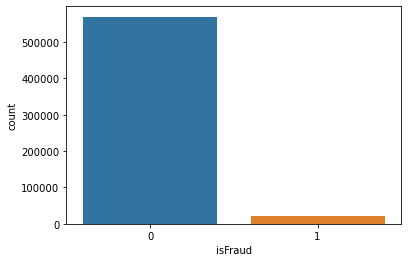

In [42]:
sns.countplot(x=train_df["isFraud"]);

Iš histogramos matomas akivaizdus klasių disbalansas.

### 2.2. Praleistos reikšmės

Funkcija parodo kintamuosius, kurių praleistų reikšmių procentas viršija tam tikrą ribą. 

In [43]:
def missing_values(df,n = 20, temp = 80):    
    dff = (df.isnull().sum()/df.shape[0])*100
    dff = dff.reset_index()
    dff.columns = ['column','percent']
    dff = dff.sort_values(by=['percent'],ascending=False).reset_index(drop=True)
    print(f'{df.isnull().any().sum()} columns : missing values.')
    print(f'{dff[dff["percent"] > temp].shape[0]} columns : missing percents more than {temp}%')
    if n:
        return dff.head(n)
    else:
        return dff

In [44]:
missing_values(train_df)

414 columns : missing values.
74 columns : missing percents more than 80%


,column,percent
0,id_24,99.196159
1,id_25,99.130965
2,id_08,99.127070
3,id_07,99.127070
4,id_21,99.126393
5,id_26,99.125715
6,id_27,99.124699
7,id_23,99.124699
8,id_22,99.124699
9,dist2,93.628374


In [45]:
missing_values(test_df)

385 columns : missing values.
71 columns : missing percents more than 80%


,column,percent
0,id_24,99.064519
1,id_25,99.005508
2,id_26,99.003929
3,id_21,99.001561
4,id_07,99.001561
5,id_08,99.001561
6,id_27,99.000969
7,id_23,99.000969
8,id_22,99.000969
9,dist2,92.809030


### 2.3. Ar yra reikšminga koreliacija tarp kintamųjų?

**C1-C14**: skaičiavimas, pvz., kiek adresų rasta susietų su mokėjimo kortele ir pan. 

<AxesSubplot:>

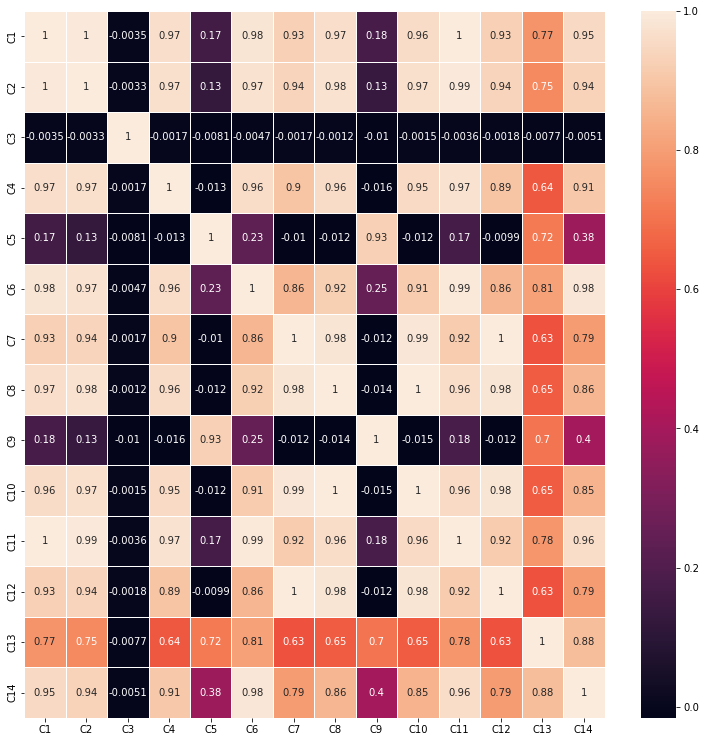

In [46]:
corr = train_df.iloc[:, 16:30].corr()
fig, ax = plt.subplots(figsize=(13, 13))
sns.heatmap(corr, linewidths=.5, annot=True, ax=ax)

Pirsono tiesinės koreliacijos koeficientas lygus 1 tarp kintamųjų: C1 ir C11, C1 ir C2, C7 ir C12, C8 ir C10. Veliau bus galima pabanduti iš rinkinio pašalinti C1, C7, C8. 

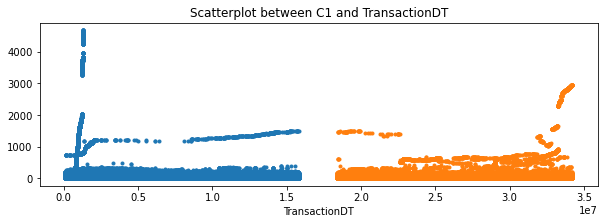

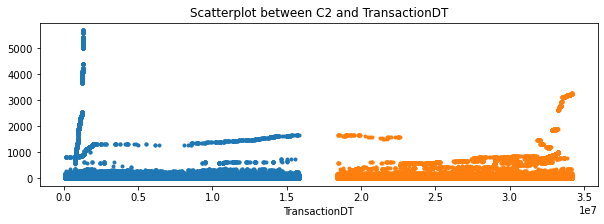

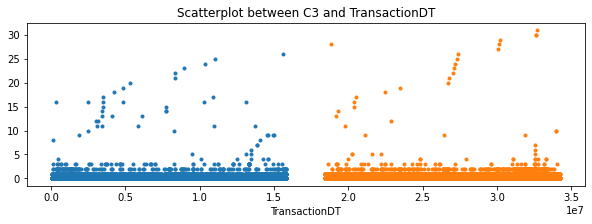

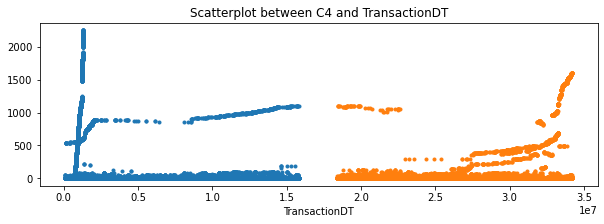

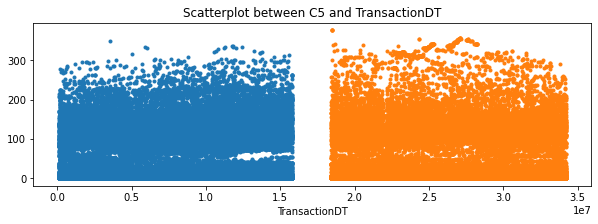

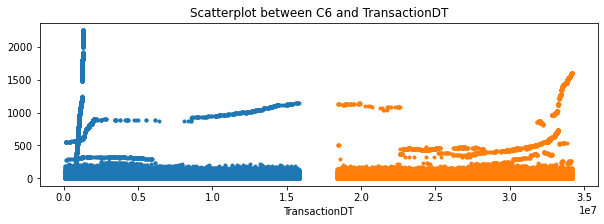

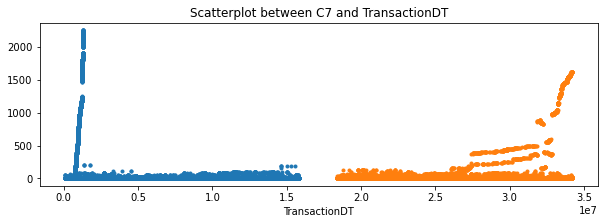

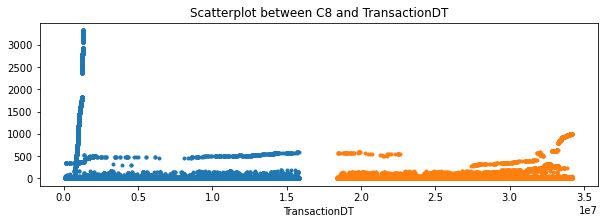

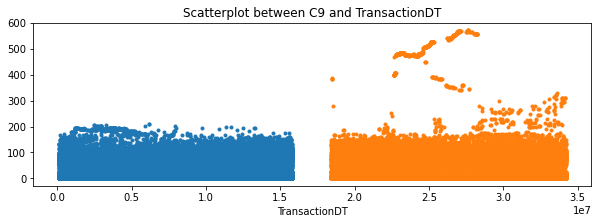

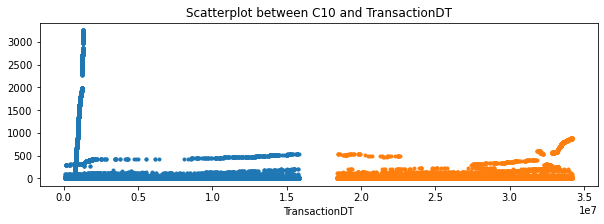

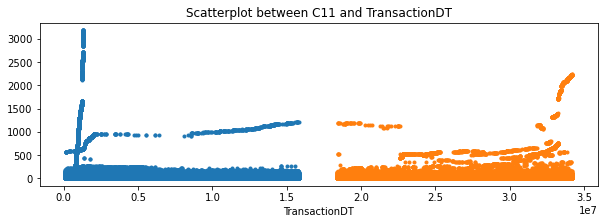

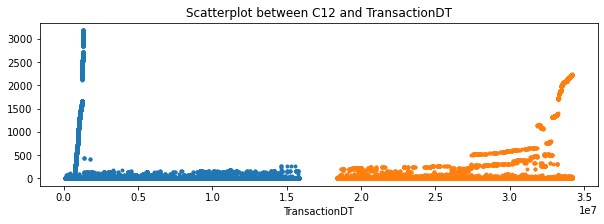

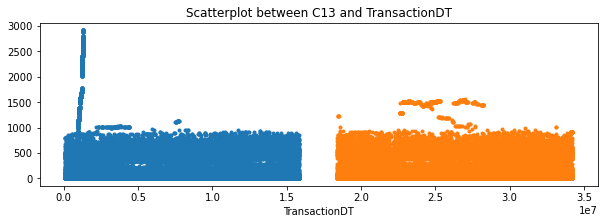

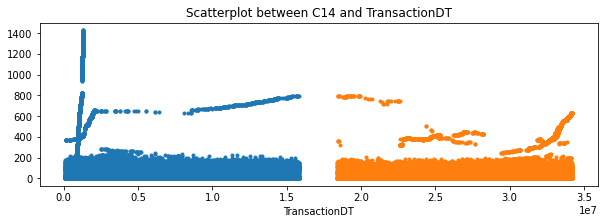

In [47]:
c_features = list(train_df.columns[16:30])
for i in c_features:
    train_df.set_index('TransactionDT')[i] \
    .plot(style='.', title=f'Scatterplot between {i} and TransactionDT',
          figsize=(10, 3))
    test_df.set_index('TransactionDT')[i] \
    .plot(style='.', figsize=(10, 3))
    plt.show()

**D1-D15**: laiko skirtumas tarp ankstesnės operacijos ir kt.

<AxesSubplot:>

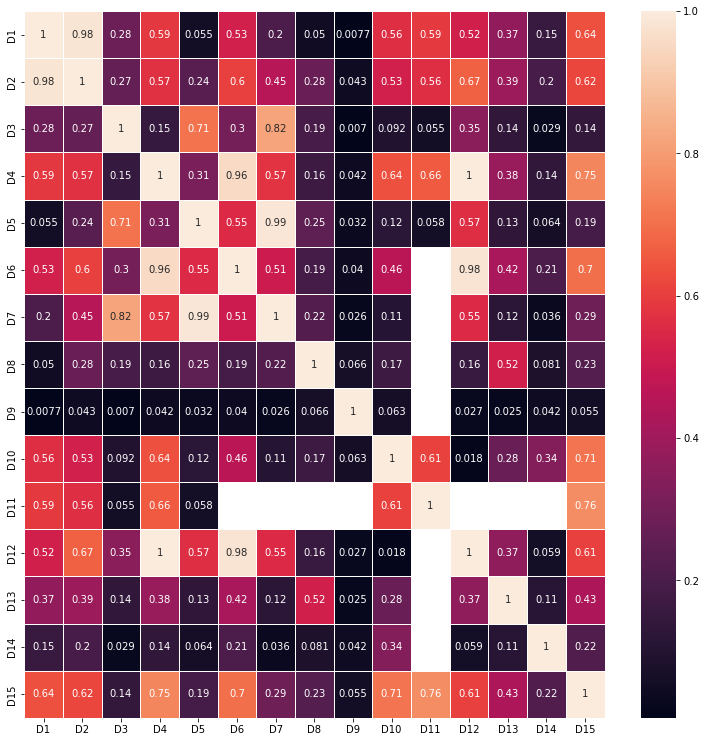

In [48]:
corr = train_df.iloc[:, 30:46].corr()
fig, ax = plt.subplots(figsize=(13, 13))
sns.heatmap(corr, linewidths=.5, annot=True, ax=ax)

Aukštas koreliacijos koeficientas tarp kintamųjų: D1 ir D2; D4 ir D6, D12; D5 ir D7; D6 ir D12.  

**V1-V339**: reitingavimas, skaičiavimas ir kiti subjektų ryšiai, pav., kiek kartų mokėta kortele, ryšys su IP ir el. pašto adresu ar adresu, pasirodė per 24 valandų laikotarpį ir pan. 

<AxesSubplot:>

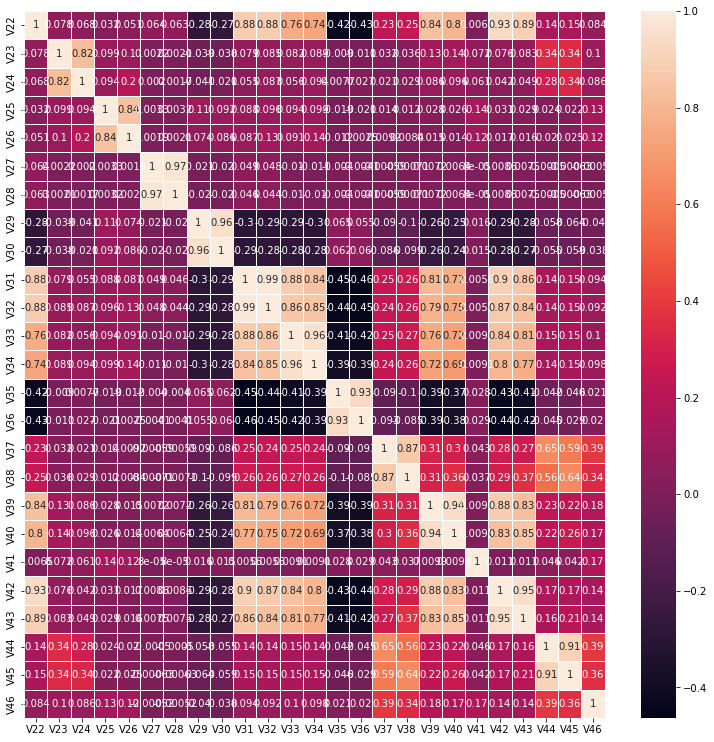

In [49]:
corr = train_df.iloc[:, 75:100].corr() # from 46
fig, ax = plt.subplots(figsize=(13, 13))
sns.heatmap(corr, linewidths=.5, annot=True, ax=ax)

Kintamųjų V koreliaciją įvertinit sudetinga dėl didelio jų skaičiaus. Didelė priklausomybe yra tarp V15 ir V16, V49 ir V48, V103 ir V97, v133 ir V134, V132 ir V143 ir daugiau.

## 3. Duomenų paruošimas

### 3.1. Kategorinių kintamųjų kodavimas 

Naudojamas metodas **OrdinalEncoder**, kuris kiekvieną kategorinio kintamojo reikšmę paverčia į sveiką skaičių nuo 0 iki n_kategorijų. 

In [68]:
for f in train_df.columns:
    if train_df[f].dtype=='object': 
        lbl = OrdinalEncoder()
        lbl.fit(list(train_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values)) 

for f in test_df.columns:
    if test_df[f].dtype=='object': 
        lbl = OrdinalEncoder()
        lbl.fit(list(test_df[f].values))
        test_df[f] = lbl.transform(list(test_df[f].values))

In [71]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 590540 entries, 2987000 to 3577539
Columns: 433 entries, isFraud to DeviceInfo
dtypes: float16(354), float32(45), int16(1), int32(32), int8(1)
memory usage: 594.5 MB


In [74]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Mem. usage decreased to 543.83 Mb (0.0% reduction)
Mem. usage decreased to 460.02 Mb (8.6% reduction)


### 3.2. Praleistų reikšmių užpildymas

In [78]:
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

### 3.3. Normalizacija (standartizacija)

In [92]:
X = train_df.drop(columns='isFraud', axis=1)
y = train_df['isFraud'].astype('int')

In [93]:
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

Duomenų rinkinis dalinamas į mokymosi ir testavimo rinkinius (20 % duomenų testavimui) 

In [94]:
X_train, X_test, y_train, y_test = train_test_split(X_minmax, y, test_size=0.2, random_state = 42, stratify=y)
print(f'X_train: {X_train.shape}, X_test{X_test.shape}')

X_train: (472432, 432), X_test(118108, 432)


### 3.2. Klasių disbalanso šalinimas

**SMOTE** metodas susintetina naujus stebėjimus mažumos klasei

Before: Counter({0: 455902, 1: 16530})
After: Counter({0: 455902, 1: 455902})
Wall time: 9.95 s


<AxesSubplot:xlabel='isFraud', ylabel='count'>

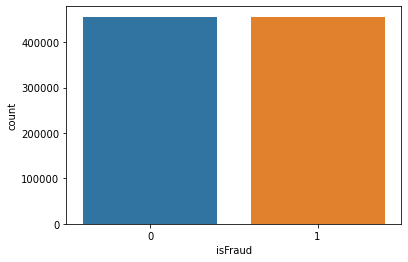

In [91]:
%%time
counter_before = Counter(y_train)
smt = SMOTE(random_state=42)
X_train_sm, y_train_sm = smt.fit_resample(X_train, y_train)

print(f'Before: {counter_before}')
print(f'After: {Counter(y_train_sm)}')

sns.countplot(x = y_train_sm);

- We will now split the train dataset into train and validation sets (20% of data for validation)

## 4. Modelio parinkimas

In [95]:
clf_rf_down = RandomForestClassifier(random_state=42)
model_rf_down = clf_rf_down.fit(X_train_sm, y_train_sm)
# y_pred = model_rf_down.predict(X_test)
y_prob = model_rf_down.predict_proba(X_test)[:, 1]
print(f'ROC-AUC score: {roc_auc_score(y_test, y_prob):.3f}')

ROC-AUC score: 0.920


## 5. Rezultato failo suformavimas

In [97]:
predictions_rf = clf_rf_down.predict_proba(test_df)[:,1]
submission = pd.DataFrame({'TransactionID':test_df.index,'isFraud':predictions_rf})
submission["TransactionID"]=submission["TransactionID"].astype(int)
submission.head()

,TransactionID,isFraud
0,3663549,0.22
1,3663550,0.37
2,3663551,0.25
3,3663552,0.27
4,3663553,0.33


In [98]:
filename = 'rf_model_submission.csv'
submission.to_csv(filename, index=False)
print(f'Saved file: {filename}')

Saved file: rf_model_submission.csv


### Rezultato pateikimas

Once you've finished your kernel and titled it, press [Save Version] > [Save & Run All (Commit)] on the top right corner of the editor screen. Wen  running your code is finished, you can go to viewer, than select data tab, where the saved files should be located. Select the relevant submission file (csv file which you saved) and press [Submit] button. Once the submission file is scored you can check the results under [My Submissions] and you will be able to see how well you did relative to the other people on the [Leaderboard].

Your [Private Score] should be better than the score of this starter notebook, which is 0.854279.